In [16]:
import random
from datetime import datetime
from typing import List, Optional
from typing import Union

import numpy as np
import torch
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image as PILImage
from torch.utils.data import DataLoader

import pyml
from diffjpeg import DiffJPEG
from models import DiscriminatorPixelMse, DiscriminatorVggMse, RandomShiftCrop

In [17]:
assert torch.cuda.is_available()

In [18]:
dataset = pyml.ImagesDataset.from_dirs_recursive(roots=["datasets/flowers102processed"], channels_order='chw')
batch_size = 1
b_m = batch_size / 8

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device='cuda')
srgan256_v0 = "/mnt/evo1gb/datasets/2023/srgan256_v0"
srgan256_v1 = "/mnt/evo1gb/datasets/2023/srgan256_v1"

squares_all = pyml.ImagesDataset.from_dirs_recursive([srgan256_v0, srgan256_v1], shuffle_seed=12, channels_order="chw")

data_loader_all = DataLoader(squares_all, batch_size=batch_size, shuffle=True, pin_memory=True,
                             pin_memory_device='cuda')

len(data_loader_all)

378533

In [19]:
class RandomJPEG(nn.Module):
    def __init__(self, size: int, qualities: List[int], seed: int = 12):
        super(RandomJPEG, self).__init__()
        self.jpegers = nn.ParameterList(
            [DiffJPEG(height=size, width=size, differentiable=False, quality=q) for q in qualities])
        self.dummy = nn.Parameter(torch.zeros(size=[1]))
        self.random = random.Random(seed)

    def __call__(self, x: torch.Tensor, jpeger_no: Optional[int] = None):
        if jpeger_no is None:
            jpeger = self.random.choice(self.jpegers)
        else:
            jpeger = self.jpegers[jpeger_no]

        return jpeger(x.to(self.dummy.device)).to(x.device)


In [20]:
class DenseResidualBlock(nn.Module):
    def __init__(self, channels: int, res_scale: float = 0.2, layers: int = 5):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale

        blocks = []
        for i in range(1, layers):
            blocks.append(nn.Sequential(
                nn.Conv2d(i * channels, channels, kernel_size=3, padding='same', bias=True),
                nn.LeakyReLU(0.1, inplace=True)
            ))

        self.blocks = torch.nn.ParameterList(blocks)
        self.last_conv = nn.Conv2d(layers * channels, channels, kernel_size=3, padding='same', bias=True)

    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)

        return x + self.last_conv(inputs) * self.res_scale


class MyDilatedBlock(nn.Module):
    def __init__(self, channels: int, res_scale: float = 0.2):
        super(MyDilatedBlock, self).__init__()

        self.res_scale: float = res_scale

        self.layers = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=True),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, dilation=2, padding=2, bias=True),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, dilation=4, padding=4, bias=True),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1, bias=True)
        )

    def forward(self, x):
        return x + self.layers(x) * self.res_scale


class MyResidualInResidualDenseBlock(nn.Module):
    def __init__(self, filters, res_scale=0.2, dr_layers: int = 5):
        super(MyResidualInResidualDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            MyDilatedBlock(filters),
            DenseResidualBlock(filters, layers=dr_layers),
            MyDilatedBlock(filters),
            DenseResidualBlock(filters, layers=dr_layers),
            MyDilatedBlock(filters),
            DenseResidualBlock(filters, layers=dr_layers)
        )

    def forward(self, x):
        return x + self.dense_blocks(x) * self.res_scale


class GeneratorRRDBx2(nn.Module):
    def __init__(self, channels: int = 64, num_res_blocks=16):
        super(GeneratorRRDBx2, self).__init__()

        upscale = 2

        self.layers = nn.Sequential(
            nn.Conv2d(3, channels, kernel_size=5, padding='same'),

            *[MyResidualInResidualDenseBlock(channels, dr_layers=3) for _ in range(num_res_blocks)],
            # RRDB much more heavy-weight than other layers

            nn.Conv2d(channels, channels * 2, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(channels * 2, 64 * upscale ** 2, kernel_size=1, padding='same'),
            nn.LeakyReLU(0.1, inplace=True),
            nn.PixelShuffle(upscale_factor=upscale),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding='same'),
        )

    def forward(self, x):
        return self.layers(x)

In [21]:
class DiscriminatorDilationNetwork(nn.Module):
    def __init__(self,
                 generator_weight: float,
                 mid_channels: int):
        super(DiscriminatorDilationNetwork, self).__init__()

        self.generator_weight: float = generator_weight
        self.random_crop = RandomShiftCrop(8)

        self.layers = nn.Sequential(
            self.conv(3, mid_channels, kernel_size=5),
            self.conv(mid_channels, mid_channels, kernel_size=3),
            nn.MaxPool2d(2),

            self.conv(mid_channels, mid_channels * 2, kernel_size=3),
            self.conv(mid_channels * 2, mid_channels * 2, kernel_size=3),
            nn.MaxPool2d(2),

            self.conv(mid_channels * 2, mid_channels * 4, kernel_size=3),
            self.conv(mid_channels * 4, mid_channels * 4, kernel_size=3),
            nn.MaxPool2d(2),

            self.conv(mid_channels * 4, mid_channels * 8, kernel_size=3),
            self.dilated_conv3(mid_channels * 8, mid_channels * 8, dilation=2),
            self.dilated_conv3(mid_channels * 8, mid_channels * 8, dilation=4),
            self.conv(mid_channels * 8, mid_channels * 8, kernel_size=3),

            self.conv(mid_channels * 8, mid_channels * 16, kernel_size=1),
            self.conv(mid_channels * 16, mid_channels, kernel_size=1),
            nn.Conv2d(mid_channels, 1, kernel_size=1)
        )

        self.binary_crossentropy_with_sigmoid = torch.nn.BCEWithLogitsLoss()

    def conv(self, in_ch: int, out_ch: int, kernel_size: int = 3) -> torch.nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='same', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1, inplace=True),
        )

    def dilated_conv3(self, in_ch: int, out_ch: int, *, dilation: int) -> torch.nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, dilation=dilation, padding=dilation, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1, inplace=True),
        )

    def loss_for_discriminator(self,
                               y: torch.Tensor,
                               label: torch.Tensor) -> torch.Tensor:
        y, label = self.random_crop(y, label)

        diff = self(y) - self(label)
        # realness(label) should be >> realness(y)
        zeros = torch.zeros(size=diff.size(), device=diff.device)
        return self.binary_crossentropy_with_sigmoid(diff, zeros)

    def loss(self,
             y: torch.Tensor,
             label: torch.Tensor) -> torch.Tensor:
        if self.generator_weight == 0.0:
            return torch.zeros(size=[1], device=y.get_device())

        y, label = self.random_crop(y, label)

        pred_y = self(y)
        pred_label = self(label)
        y_more_real = pred_y > pred_label

        diff = y_more_real * 9000 + ~y_more_real * (pred_y - pred_label)
        ones = torch.ones(size=diff.size()).to(diff.device)
        return self.binary_crossentropy_with_sigmoid(diff, ones) * self.generator_weight

    def forward(self, y: torch.Tensor) -> torch.Tensor:
        y = self.layers(y)
        return y

In [10]:
import time

time.time()

1687541701.183323

In [24]:
class GanHelper:
    def __init__(self, data_loader: DataLoader):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.data_loader = data_loader
        scale = 2
        self.generator = GeneratorRRDBx2(channels=64, num_res_blocks=16).to(self.device)

        self.d_pixel_mse = DiscriminatorPixelMse(weight=1.0)
        self.d_vgg_mse = DiscriminatorVggMse(weight=0.0001, inpad_size=0).to(self.device)
        self.d_vgg_mse_x2 = DiscriminatorVggMse(weight=0.0001, prescale=2, inpad_size=0).to(self.device)
        self.d_baseline = DiscriminatorDilationNetwork(generator_weight=0.0003, mid_channels=32).to(self.device)

        self.jpeger = RandomJPEG(size=256 // scale, qualities=[50, 70, 80, 90, 95, 99]).to(self.device)
        self.losses = []
        self.losses_print_step = 1000

    def add_loss(self, losses: List[torch.Tensor]):
        self.losses.append([loss.item() for loss in losses])
        if self.losses_print_step is not None and len(self.losses) % self.losses_print_step == 0:
            av_loss = np.average(np.array(self.losses[-self.losses_print_step:]), axis=0)
            print(f"{len(self.losses)}: {av_loss}")

    def generate_data(self):
        while True:
            for label in self.data_loader:
                yield label

    @staticmethod
    def downsample(x: torch.Tensor, factor: int) -> torch.Tensor:
        _, _, h, w = x.size()
        return F.interpolate(x, size=(h // factor, w // factor), mode='bilinear', antialias=True)

    @staticmethod
    def upsample(x: torch.Tensor, factor: int) -> torch.Tensor:
        _, _, h, w = x.size()
        return F.interpolate(x, size=(h * factor, w * factor), mode='bilinear')

    def train(self, *, steps: int, lr_g: float = 0.0, lr_d: float = 0.0, d_steps: int = 1):
        generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr_g)
        discriminator_optimizer = torch.optim.Adam(self.d_baseline.parameters(), lr=lr_d)

        self.generator.train()
        self.d_baseline.train()

        for step, label in zip(range(steps), self.generate_data()):
            t0 = time.time()
            label = label.to(self.device)
            label.requires_grad = False
            t1 = time.time()

            with torch.no_grad():
                x = self.downsample(label, 2)
                x = self.jpeger(x)
            t2 = time.time()
            print(f"move time: {t1 - t0} prepare time: {t2 - t1}")

            saved_y: Optional[torch.Tensor] = None

            # train generator
            if lr_g != 0.0:
                t3 = time.time()
                generator_optimizer.zero_grad(set_to_none=True)
                t4 = time.time()
                y = self.generator(x)
                t5 = time.time()
                saved_y = y.detach()
                g_losses = [f.loss(y, label) for f in
                            [self.d_pixel_mse, self.d_vgg_mse, self.d_vgg_mse_x2, self.d_baseline]]
                loss = sum(g_losses)
                loss.backward()
                t6 = time.time()
                generator_optimizer.step()
                t7 = time.time()
                print(f"generator tolal: {t7 - t3}, zero grad {t4 - t3}, gen(x) {t5 - t4}, backward {t6 - t5}, step {t7 - t6}")
            else:
                g_losses = [torch.zeros(size=[1], device=self.device) for _ in range(4)]

            # train discriminator
            if lr_d != 0.0:

                if saved_y is not None:
                    y = saved_y
                else:
                    with torch.no_grad():
                        y = self.generator(x).detach()

                for d_step in range(d_steps):
                    t8 = time.time()
                    discriminator_optimizer.zero_grad()
                    t9 = time.time()
                    d_loss = self.d_baseline.loss_for_discriminator(y, label)
                    t10 = time.time()
                    d_loss.backward()
                    t11 = time.time()
                    discriminator_optimizer.step()
                    t12 = time.time()
                    print(f"d tolal: {t12 - t8}, zero grad {t9 - t8}, gen(x) {t10 - t9}, backward {t11 - t10}, step {t12 - t11}")
            else:
                d_loss = torch.zeros(size=[1], device=self.device)

            self.add_loss(g_losses + [d_loss])

    def eval(self, x: torch.Tensor):
        with torch.no_grad():
            return self.generator(x)

    def demonstrate(self, label: Union[np.ndarray, torch.Tensor], jpeger_no: Optional[int] = None) -> PILImage:
        if isinstance(label, np.ndarray):
            if len(label.shape) == 3:
                label = label[np.newaxis]
            label = torch.from_numpy(label)
        assert isinstance(label, torch.Tensor)
        label = label.to(self.device)

        scale = 2
        self.generator.eval()
        x = self.downsample(label, scale)
        if jpeger_no is not None:
            x = self.jpeger(x, jpeger_no)

        y = self.generator(x)
        x4x = self.upsample(x, scale)

        triple = torch.cat([x4x, y, label], dim=3)
        pic = triple.cpu().detach().numpy()[0]
        pic = np.moveaxis(pic, 0, 2)
        pic = np.clip(pic, 0.0, 1.0)
        img = PILImage.fromarray((pic * 255.0).astype(np.uint8))
        return img

    def save_model(self) -> str:
        suffix = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
        torch.save(self.generator.state_dict(), f"models/espcn/generator_espcn_{suffix}.pth")
        torch.save(self.d_baseline.state_dict(), f"models/espcn/discriminator_baseline_{suffix}.pth")
        return suffix

    def load_model(self, suffix: str):
        self.generator.load_state_dict(torch.load(f"models/espcn/generator_espcn_{suffix}.pth"))
        self.d_baseline.load_state_dict(torch.load(f"models/espcn/discriminator_baseline_{suffix}.pth"))

In [12]:
from matplotlib import pyplot as plt


def show_plt(av: int, y_min: float = 0.0001, y_max: float = 1.0):
    plt.rcParams['figure.figsize'] = [12, 12]
    fig, ax = plt.subplots()
    ax.set_yscale("log")
    ax.set_ylim(y_min, y_max)

    def my_plot(lst: List[float], av: int):
        for i, color in enumerate(["red", "green", "blue", "yellow", "magenta"]):
            arr = np.array(lst)[:, i]
            arr = arr[:arr.shape[0] // av * av]
            arr = arr.reshape(-1, av).mean(axis=1)
            ax.plot([i * av for i in range(arr.shape[0])], arr, c=color)

    my_plot(gan_helper.losses, av=av)

    ax.legend()
    plt.show()

In [25]:
gan_helper = GanHelper(data_loader_all)

In [14]:
gan_helper.losses_print_step = 1000
gan_helper.train(steps=50, lr_g=0.0001 * b_m, lr_d=0.0001 * b_m, d_steps=10)

move time: 0.00011324882507324219 prepare time: 0.8904657363891602
generator tolal: 1.5390334129333496, zero grad 0.000400543212890625, gen(x) 0.8601136207580566, backward 0.5559394359588623, step 0.12257981300354004
d tolal: 0.015152931213378906, zero grad 0.0004086494445800781, gen(x) 0.0077266693115234375, backward 0.004068136215209961, step 0.0029494762420654297
d tolal: 0.009762763977050781, zero grad 0.00019359588623046875, gen(x) 0.003344297409057617, backward 0.003988504409790039, step 0.0022363662719726562
d tolal: 0.01146554946899414, zero grad 0.00019240379333496094, gen(x) 0.0032203197479248047, backward 0.0058438777923583984, step 0.0022089481353759766
d tolal: 0.012460470199584961, zero grad 0.0001881122589111328, gen(x) 0.0031614303588867188, backward 0.006905555725097656, step 0.002205371856689453
d tolal: 0.01418447494506836, zero grad 0.00018739700317382812, gen(x) 0.0031692981719970703, backward 0.007081270217895508, step 0.003746509552001953
d tolal: 0.0143339633941

In [15]:
gan_helper.losses_print_step = 1000
gan_helper.d_vgg_mse_x2.weight = 0.0
gan_helper.train(steps=2, lr_g=0.0001 * b_m, lr_d=0.0001 * b_m, d_steps=1)

move time: 0.005204916000366211 prepare time: 0.0014972686767578125
generator tolal: 0.6218771934509277, zero grad 0.0038428306579589844, gen(x) 0.08270120620727539, backward 0.4137227535247803, step 0.12161040306091309
d tolal: 0.011823415756225586, zero grad 0.00040030479431152344, gen(x) 0.0036301612854003906, backward 0.0049245357513427734, step 0.0028684139251708984
move time: 8.630752563476562e-05 prepare time: 0.0012128353118896484
generator tolal: 0.5546770095825195, zero grad 0.003295421600341797, gen(x) 0.05124330520629883, backward 0.3961026668548584, step 0.10403561592102051
d tolal: 0.011539220809936523, zero grad 0.00041604042053222656, gen(x) 0.004155874252319336, backward 0.004609107971191406, step 0.0023581981658935547


In [23]:
gan_helper.losses_print_step = 1000
gan_helper.d_vgg_mse_x2.weight = 0.0
gan_helper.train(steps=5, lr_g=0.0001 * b_m, lr_d=0.0001 * b_m, d_steps=1)

move time: 0.017259836196899414 prepare time: 0.0023055076599121094
generator tolal: 0.6732931137084961, zero grad 0.0058345794677734375, gen(x) 0.07759642601013184, backward 0.43695926666259766, step 0.15290284156799316
d tolal: 0.015694141387939453, zero grad 0.00032973289489746094, gen(x) 0.0051403045654296875, backward 0.006201505661010742, step 0.0040225982666015625
move time: 0.00011897087097167969 prepare time: 0.0013892650604248047
generator tolal: 0.5418057441711426, zero grad 0.0036253929138183594, gen(x) 0.05111861228942871, backward 0.38336777687072754, step 0.10369396209716797
d tolal: 0.01044464111328125, zero grad 0.0004329681396484375, gen(x) 0.0036950111389160156, backward 0.004050254821777344, step 0.002266407012939453
move time: 9.274482727050781e-05 prepare time: 0.0012524127960205078
generator tolal: 0.541839599609375, zero grad 0.0032765865325927734, gen(x) 0.05178499221801758, backward 0.38564133644104004, step 0.10113668441772461
d tolal: 0.010653972625732422, z

In [26]:
gan_helper.losses_print_step = 1000
gan_helper.d_vgg_mse_x2.weight = 0.0
gan_helper.train(steps=5, lr_g=0.0001 * b_m, lr_d=0.0001 * b_m, d_steps=1)

move time: 0.0001323223114013672 prepare time: 0.0020728111267089844
generator tolal: 0.6739273071289062, zero grad 0.0005667209625244141, gen(x) 0.07254958152770996, backward 0.452960729598999, step 0.14785027503967285
d tolal: 0.016964197158813477, zero grad 0.0003681182861328125, gen(x) 0.006057024002075195, backward 0.006254673004150391, step 0.004284381866455078
move time: 0.0001289844512939453 prepare time: 0.0018048286437988281
generator tolal: 0.5388405323028564, zero grad 0.0014126300811767578, gen(x) 0.05302000045776367, backward 0.3759019374847412, step 0.1085059642791748
d tolal: 0.012694120407104492, zero grad 0.00045418739318847656, gen(x) 0.0038328170776367188, backward 0.005791187286376953, step 0.0026159286499023438
move time: 9.083747863769531e-05 prepare time: 0.001241445541381836
generator tolal: 0.5385868549346924, zero grad 0.0009603500366210938, gen(x) 0.05073881149291992, backward 0.37691235542297363, step 0.10997533798217773
d tolal: 0.012115955352783203, zero 

In [29]:
torch.backends.cudnn.benchmark = True
gan_helper.losses_print_step = 1000
gan_helper.d_vgg_mse_x2.weight = 0.0
gan_helper.train(steps=5, lr_g=0.0001 * b_m, lr_d=0.0001 * b_m, d_steps=1)

move time: 0.017482995986938477 prepare time: 0.002436399459838867
generator tolal: 0.6994423866271973, zero grad 0.0017018318176269531, gen(x) 0.10033488273620605, backward 0.4568188190460205, step 0.14058685302734375
d tolal: 0.011521339416503906, zero grad 0.00024271011352539062, gen(x) 0.0038335323333740234, backward 0.0043871402740478516, step 0.0030579566955566406
move time: 9.34600830078125e-05 prepare time: 0.0014142990112304688
generator tolal: 0.5429067611694336, zero grad 0.0011413097381591797, gen(x) 0.0567324161529541, backward 0.37726831436157227, step 0.10776472091674805
d tolal: 0.012034177780151367, zero grad 0.0003952980041503906, gen(x) 0.003802061080932617, backward 0.005570888519287109, step 0.00226593017578125
move time: 9.012222290039062e-05 prepare time: 0.0013110637664794922
generator tolal: 0.5336084365844727, zero grad 0.0010867118835449219, gen(x) 0.05068325996398926, backward 0.37392330169677734, step 0.10791516304016113
d tolal: 0.010550737380981445, zero 

In [34]:
torch.backends.cudnn.benchmark = True
gan_helper.losses_print_step = 1000
gan_helper.d_vgg_mse_x2.weight = 0.0
with torch.autocast(device_type='cuda', dtype=torch.float16):
    gan_helper.train(steps=5, lr_g=0.0001 * b_m, lr_d=0.0001 * b_m, d_steps=1)

move time: 0.010144710540771484 prepare time: 0.0014386177062988281
generator tolal: 2.3082547187805176, zero grad 0.0012295246124267578, gen(x) 0.30982112884521484, backward 1.9382717609405518, step 0.05893230438232422
d tolal: 0.013692617416381836, zero grad 0.00035834312438964844, gen(x) 0.005304813385009766, backward 0.005064964294433594, step 0.002964496612548828
move time: 8.7738037109375e-05 prepare time: 0.001901865005493164
generator tolal: 0.20616626739501953, zero grad 0.0015306472778320312, gen(x) 0.039249420166015625, backward 0.12560629844665527, step 0.0397799015045166
d tolal: 0.012714862823486328, zero grad 0.0002872943878173828, gen(x) 0.003961324691772461, backward 0.006254434585571289, step 0.0022118091583251953
move time: 9.417533874511719e-05 prepare time: 0.0017490386962890625
generator tolal: 0.19356775283813477, zero grad 0.0012853145599365234, gen(x) 0.03843879699707031, backward 0.11316418647766113, step 0.0406794548034668
d tolal: 0.01294088363647461, zero g

In [31]:
gan_helper.losses_print_step = 10000
gan_helper.train(steps=10000, lr_g=0.0001 * b_m, lr_d=0.0001 * b_m, d_steps=10)
gan_helper.train(steps=10000, lr_g=0.00003 * b_m, lr_d=0.0001 * b_m, d_steps=10)
gan_helper.train(steps=20000, lr_g=0.00001 * b_m, lr_d=0.0001 * b_m, d_steps=10)
gan_helper.train(steps=40000, lr_g=0.00003 * b_m, lr_d=0.00003 * b_m, d_steps=10)
gan_helper.train(steps=40000, lr_g=0.00001 * b_m, lr_d=0.00001 * b_m, d_steps=10)
gan_helper.train(steps=80000, lr_g=0.000003 * b_m, lr_d=0.000003 * b_m, d_steps=10)
gan_helper.train(steps=80000, lr_g=0.000001 * b_m, lr_d=0.000001 * b_m, d_steps=10)
gan_helper.train(steps=80000, lr_g=0.0000003 * b_m, lr_d=0.0000003 * b_m, d_steps=10)
model_suffix = gan_helper.save_model()
print(model_suffix)

show_plt(av=1000)

move time: 0.00012254714965820312 prepare time: 0.0014538764953613281
generator tolal: 0.5919427871704102, zero grad 0.001435995101928711, gen(x) 0.07202553749084473, backward 0.39417386054992676, step 0.12430739402770996
d tolal: 0.011263847351074219, zero grad 0.0003895759582519531, gen(x) 0.0035729408264160156, backward 0.004361391067504883, step 0.002939939498901367
d tolal: 0.009630203247070312, zero grad 0.00019431114196777344, gen(x) 0.003235340118408203, backward 0.003954410552978516, step 0.0022461414337158203
d tolal: 0.009683847427368164, zero grad 0.00019288063049316406, gen(x) 0.0033075809478759766, backward 0.00391840934753418, step 0.0022649765014648438
d tolal: 0.014416933059692383, zero grad 0.0001914501190185547, gen(x) 0.003275632858276367, backward 0.0038814544677734375, step 0.0070683956146240234
d tolal: 0.014471054077148438, zero grad 0.00019598007202148438, gen(x) 0.003291606903076172, backward 0.0038824081420898438, step 0.0071010589599609375
d tolal: 0.0152821

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


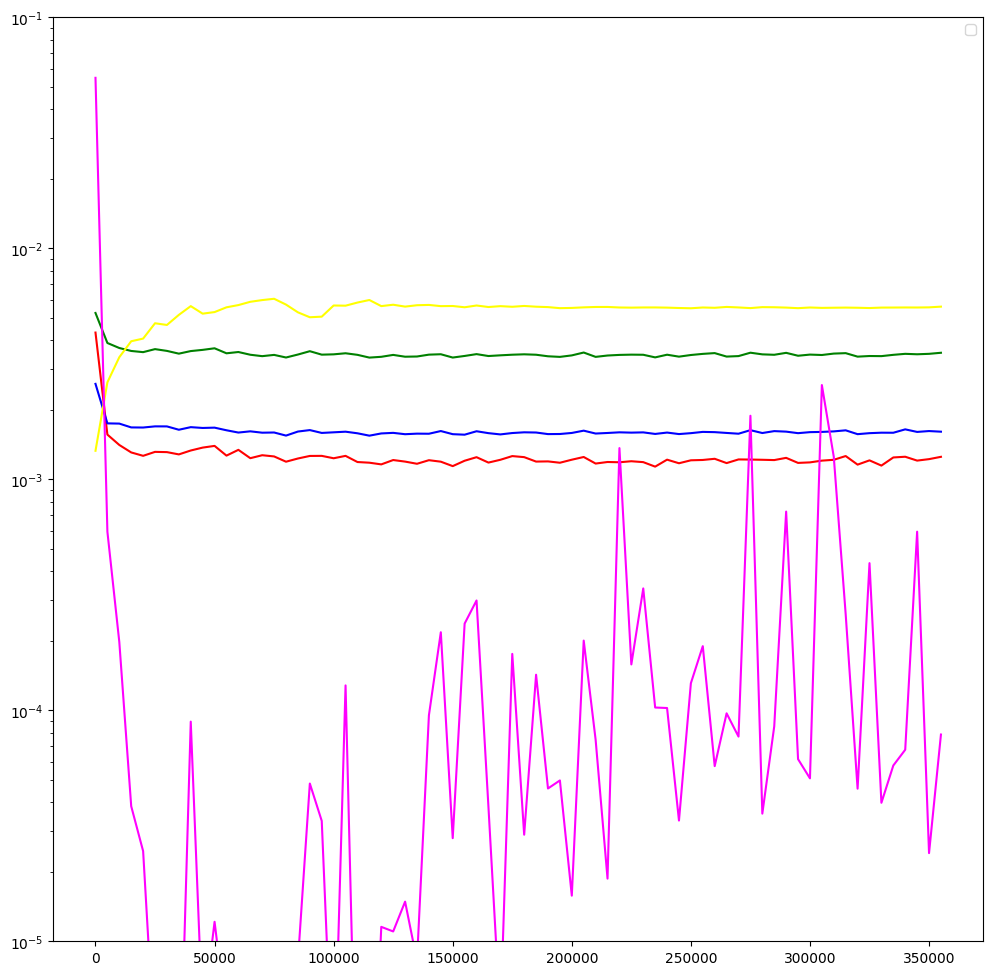

In [15]:
show_plt(av=5000, y_min=0.00001, y_max=0.1)

In [12]:
model_suffix = gan_helper.save_model()
model_suffix

'2023-05-19-20-48-23'

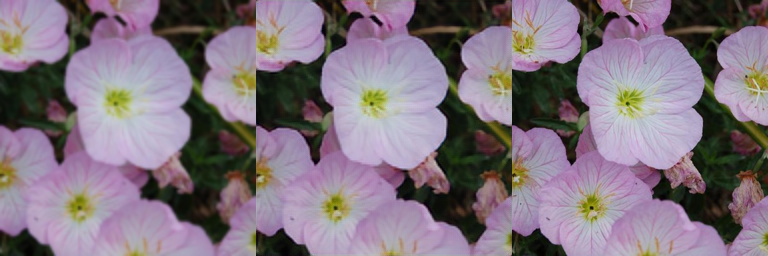

In [16]:
gan_helper.demonstrate(dataset[0])

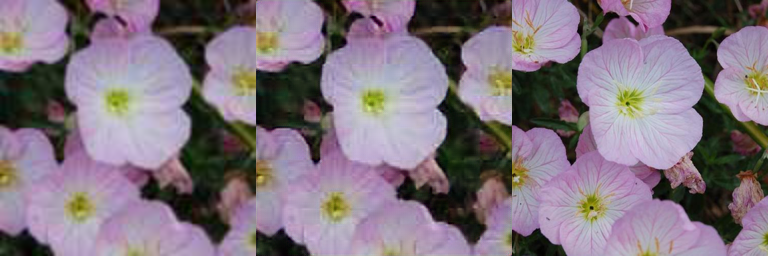

In [17]:
gan_helper.demonstrate(dataset[0], jpeger_no=0)

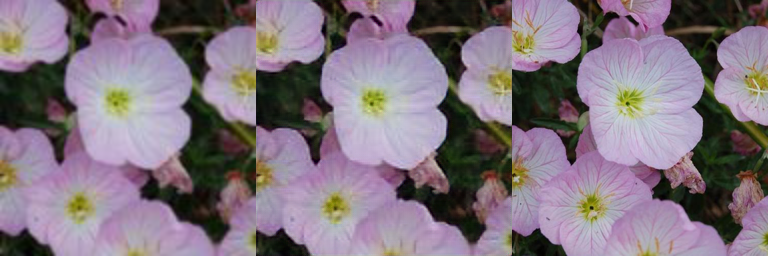

In [18]:
gan_helper.demonstrate(dataset[0], jpeger_no=2)

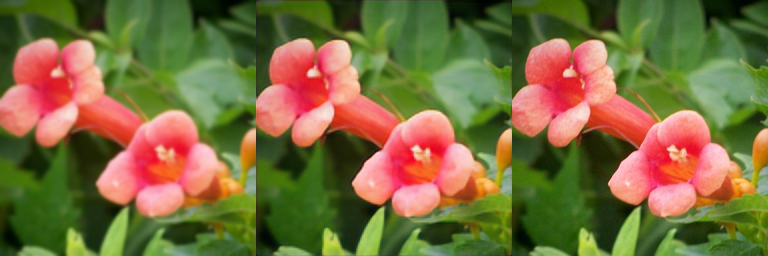

In [19]:
gan_helper.demonstrate(dataset[6])

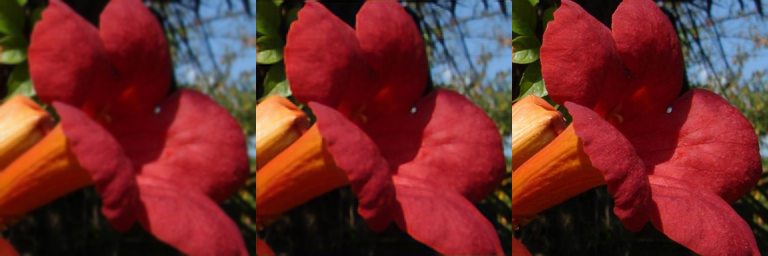

In [20]:
gan_helper.demonstrate(dataset[7])

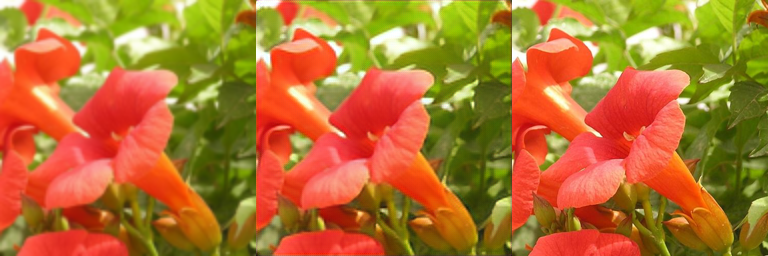

In [21]:
gan_helper.demonstrate(dataset[8])

In [22]:
g = GeneratorRRDBx2(channels=64, num_res_blocks=16)
g.load_state_dict(torch.load(f"models/espcn/generator_espcn_{model_suffix}.pth"))
g.to('cuda')

saver = pyml.ImageSaver(f'/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/{model_suffix}-pics')

demo_data = pyml.ImagesDataset.from_dirs_recursive(
    roots=["/mnt/pi8-v2/mnt/safedata/datasets/2020/torrent/windows"],
    shuffle_seed=12,
    channels_order='chw'
)

for i in range(500):
    src = demo_data[i]
    if src is None:
        continue
    if src.shape[1] > 1280 or src.shape[2] > 1280:
        continue

    batch = torch.from_numpy(src[np.newaxis])
    with torch.no_grad():
        y = g(batch.to('cuda')).cpu()
    saver.saveCHW(src)
    saver.saveCHW(y.detach().numpy()[0])
    print(".", end='.')

..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [23]:
import PIL.ImageOps

saver2 = pyml.ImageSaver(f'/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/{model_suffix}-pics-l')

for i in range(1000):
    src = demo_data[i]
    if src is None:
        continue
    if src.shape[1] <= 1280 and src.shape[2] <= 1280:
        continue
    pil_image = PILImage.open(demo_data.images_paths[i])
    pil_image = PIL.ImageOps.exif_transpose(pil_image)
    pil_image = pil_image.convert('RGB')
    w, h = pil_image.size
    k = 512.0 / max(h, w)
    pil_image = pil_image.resize(size=(int(w * k), int(h * k)))

    np_array = np.asarray(pil_image).astype(np.float32) / 255.0
    np_array = np.moveaxis(np_array, 2, 0)

    batch = torch.from_numpy(np_array[np.newaxis])
    with torch.no_grad():
        y = g(batch.to('cuda')).cpu()
    saver2.saveCHW(np_array)
    saver2.saveCHW(y.detach().numpy()[0])
    print(".", end='.')

..................................................................................................................................................................................................................................................................................................................................................................................................

In [24]:
data = pyml.ImagesDataset.from_dirs_recursive(
    roots=["/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples"],
    channels_order='chw'
)
data.images_paths

['/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210507_195012.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210507_200212.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210524_100644(0).jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210524_100941.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210526_133529.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210527_145012.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210604_100509.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210605_232353.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210621_140736.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/20210621_140740.jpg',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/examples/IMG_0280.JPG',
 '/mnt/pi8-v2/mnt/safedata/backups/2023/neural 

In [25]:
g = GeneratorRRDBx2(channels=64, num_res_blocks=16)
g.load_state_dict(torch.load(f"models/espcn/generator_espcn_{model_suffix}.pth"))
g.eval().to('cuda')

print(f"model_suffix = {model_suffix}")

saver = pyml.ImageSaver(f'/mnt/pi8-v2/mnt/safedata/backups/2023/neural networks/{model_suffix}-demo')


def demo(src: np.ndarray):
    with torch.no_grad():
        batch = torch.from_numpy(src[np.newaxis]).to('cuda')

        while batch.size(2) > 512 or batch.size(3) > 512:
            batch = gan_helper.downsample(batch, 2)

        saver.saveCHW(batch.detach().cpu().numpy()[0], name_prefix='src_')
        print(f"src saved: batch.size() = {batch.size()}")
        while batch.size(2) <= 1024 or batch.size(3) <= 1024:
            batch = g(batch)
            saver.saveCHW(batch.detach().cpu().numpy()[0])
            print(f"saved: batch.size() = {batch.size()}")


for pic in data:
    demo(pic)

g = None

model_suffix = 2023-05-19-20-48-23
src saved: batch.size() = torch.Size([1, 3, 504, 378])
saved: batch.size() = torch.Size([1, 3, 1008, 756])
saved: batch.size() = torch.Size([1, 3, 2016, 1512])
src saved: batch.size() = torch.Size([1, 3, 378, 504])
saved: batch.size() = torch.Size([1, 3, 756, 1008])
saved: batch.size() = torch.Size([1, 3, 1512, 2016])
src saved: batch.size() = torch.Size([1, 3, 378, 504])
saved: batch.size() = torch.Size([1, 3, 756, 1008])
saved: batch.size() = torch.Size([1, 3, 1512, 2016])
src saved: batch.size() = torch.Size([1, 3, 378, 504])
saved: batch.size() = torch.Size([1, 3, 756, 1008])
saved: batch.size() = torch.Size([1, 3, 1512, 2016])
src saved: batch.size() = torch.Size([1, 3, 378, 504])
saved: batch.size() = torch.Size([1, 3, 756, 1008])
saved: batch.size() = torch.Size([1, 3, 1512, 2016])
src saved: batch.size() = torch.Size([1, 3, 378, 504])
saved: batch.size() = torch.Size([1, 3, 756, 1008])
saved: batch.size() = torch.Size([1, 3, 1512, 2016])
src s

In [13]:
g = GeneratorRRDBx2(channels=64, num_res_blocks=16)
model_suffix = '2023-05-19-20-48-23'
g.load_state_dict(torch.load(f"models/espcn/generator_espcn_{model_suffix}.pth"))
g.eval().to('cuda')

print(f"model_suffix = {model_suffix}")

saver = pyml.ImageSaver(f'{model_suffix}-demo/')


def demo(src: np.ndarray, initial_downscale: int = 1):
    with torch.no_grad():
        batch = torch.from_numpy(src[np.newaxis]).to('cuda')

        if initial_downscale != 1:
            batch = GanHelper.downsample(batch, initial_downscale)

        saver.saveCHW(batch.detach().cpu().numpy()[0], name_prefix='src_')
        batch = g(batch)
        saver.saveCHW(batch.detach().cpu().numpy()[0])


data = pyml.ImagesDataset.from_dirs_recursive(roots=["datasets/example_images"], channels_order='chw')

for pic in data:
    for downscale in [1, 2, 4]:
        demo(pic, initial_downscale=downscale)

model_suffix = 2023-05-19-20-48-23


In [17]:
from math import prod

sum(prod(p.size()) for p in g.parameters())

16293763